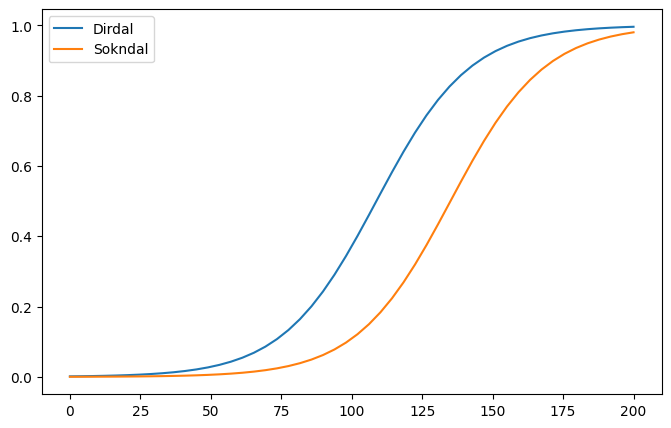

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Beta = 0.06
Population_in_Dirdal = 683
Population_in_Sokndal = 3305
Starting_Zombies = 1
Timesteps = np.linspace(0, 200)

class Zombie_outbreak_task_1:
    def __init__(self, location, population,beta, Timesteps, Starting_Zombies):
        """
        This Function defines the object of which we are to draw the plot, instantiating the object is enough to call the plot,
        though it can be plotted sepparately using object.plot() at any time
        
        args:
        location is the location as string, for instance 'Dirdal'
        population sets the starting population of the village as int, for instance 683
        beta is an infection constant as float, here it is always 0.06, but if need be it can be changed, hence it is not hardcoded
        Timesteps is an array of integers for each timestep we wish to take, here it is an array of [0,...,199]
        Starting_Zombies lets us try different scenarios with different amount of starting zombies, for this assignment it is always 1 though.

        returns a plot of the population development
        """
        self.Location = location
        self.Population = population
        self.Initial_Zombie_Population = Starting_Zombies
        self.beta = beta
        self.Timesteps = Timesteps
        self.Healthy_Population, self.Population_Of_Zombies = self.SZ_solution()
        self.Fraction_turned_zombie = self.Fraction_is_zombie()
        self.plot()



    def SZ_solution(self):
        """TODO: Skriv Docstring"""
        initial_healthy_population = self.Population - self.Initial_Zombie_Population


        Current_Healthy_Population = (initial_healthy_population * (initial_healthy_population/self.Initial_Zombie_Population) * np.exp(-self.beta*self.Timesteps)) / (1 + (initial_healthy_population/self.Initial_Zombie_Population) * np.exp(-self.beta*self.Timesteps))


        Current_Zombie_Population = (initial_healthy_population+ self.Initial_Zombie_Population) / (1 + (initial_healthy_population/self.Initial_Zombie_Population) * np.exp(-self.beta*self.Timesteps))
        return Current_Healthy_Population, Current_Zombie_Population
    
    def Fraction_is_zombie(self):
        """TODO: Skriv Docstring"""
        fraction_of_population_turned_zombie = self.Population_Of_Zombies / self.Population
        return fraction_of_population_turned_zombie
    
    def plot(self):
        """TODO: Skriv Docstring"""
        plt.plot(self.Timesteps, self.Fraction_turned_zombie,label=self.Location)
plt.figure(figsize=(8,5))

Dirdal = Zombie_outbreak_task_1("Dirdal", Population_in_Dirdal, Beta, Timesteps,Starting_Zombies)
Sokndal = Zombie_outbreak_task_1("Sokndal", Population_in_Sokndal, Beta, Timesteps, Starting_Zombies)

#Gammel kode begynner
#S_d, Z_d = SZ_solution(t, N_dirdal)
#S_s, Z_s = SZ_solution(t, N_sokndal)

#må dele på befolkning for å få like reprensativt tall
#Z_d_frac = Z_d / N_dirdal
#Z_s_frac = Z_s / N_sokndal

# plotting
#plt.figure(figsize=(8,5))
#plt.plot(t, Z_d_frac, label="Zombies Dirdal")
#plt.plot(t, Z_s_frac, label="Zombies Sokndal")
#Gammel kode slutter


plt.legend()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class zombie_outbreak:
    def __init__(self,location, population,beta,starting_zombies = 1):
        self.Location = location
        self.Population = population
        self.starting_population = np.array([starting_zombies,self.Population-starting_zombies])
        self.starting_zombies = starting_zombies
        self.beta = beta

    def step(self, timestep, human_population_old, dt, function, method, *args, **kwargs):
        """
        Awesome doc string
        """
        if method == 'Euler':
            return dt*function(timestep, human_population_old, *args, **kwargs)
        elif method == 'RK2':
            k1 = np.array(dt*function(timestep, human_population_old, *args, **kwargs))
            return dt*function(timestep+dt*0.5, human_population_old + 0.5*k1, *args, **kwargs)
        else:
            raise ValueError('Method not implemented') 

    def ode_solver_adaptiv(self, time_start, time_end, eps, function, method, *args, **kwargs):
        '''En grunnleggende ODE solver
            Input
            -----
            t0: float, starting time
            t_final: float, end time
            eps: float, accuracy
            f: ode function (rhs) f(t,c,tau)
            tau: float, a parameter

            Output
            -----
            t, c'''
        population = [self.starting_population]
        t = [time_start]
        dt_old = 1e-1
        if method == "Euler":
            p=1
        elif method == "RK2":
            p = 2
        else:
            assert ValueError("Method is not implemented")
            
        while t[-1] < time_end:
            population_old = population[-1]
            eps_calc = 10*eps #just to enter while loop
            while eps_calc > eps:
                dt = dt_old
                population_longstep = population_old + self.step(t[-1], population_old, dt, function, method, *args, **kwargs)
                population_halfstep = population_old + self.step(t[-1], population_old, 0.5*dt, function, method, *args, **kwargs)
                population_two_half_steps = population_halfstep + self.step(t[-1]+0.5*dt, population_halfstep, 0.5*dt, function, method, *args, **kwargs)
                eps_calc = np.linalg.norm((population_longstep-population_two_half_steps)/(2**p-1))
                dt_old = dt*(eps/eps_calc)**(1/(p+1))
            population.append(population_two_half_steps)
            t.append(t[-1]+dt)
        return np.array(t), np.array(population)



    def rhs_z(self,timestep,c):
        return np.array([self.beta*c[0]*(1-c[0]/self.Population), -self.beta*c[1]*(1-c[1]/self.Population)])
    
    def SZ_solution(self,t):
        population_at_start = self.Population - self.starting_zombies
        Current_Population = (population_at_start * (population_at_start/self.starting_zombies) * np.exp(-self.beta*t)) / (1 + (population_at_start/self.starting_zombies) * np.exp(-self.beta*t))
        Current_Zombies = (population_at_start + self.starting_zombies) / (1 + (population_at_start/self.starting_zombies) * np.exp(-self.beta*t))
        return Current_Population, Current_Zombies
    
    def solve(self,time_start,Timesteps,eps, method):
        Timesteps, Zombies = self.ode_solver_adaptiv(time_start, Timesteps, eps, self.rhs_z, method)
        _, List_of_Zombies = self.SZ_solution(Timesteps)
        plt.plot(Timesteps, Zombies,'*', label=f"Zombies {self.Location}")
        plt.show
        plt.plot(Timesteps, List_of_Zombies, label=f"Zombies {self.Location} numerical")
        plt.show

dt = 0.1
eps = 1
dirdal = zombie_outbreak("Dirdal", Population_in_Dirdal,0.06)
sokndal = zombie_outbreak("sokndal", Population_in_Sokndal,0.06)
dirdal.solve(0,250,eps, "RK2")
sokndal.solve(0,250,eps, "RK2")

NameError: name 'c' is not defined